## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [ ]:
data_df = pd.read_excel('residual_arima.xlsx')
columns_name = ['Residual']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d-%m-%Y')
data_df.set_index('Date', inplace=True)

In [4]:
print(data_df.columns)

Index(['30 hPa', '25 hPa', '20 hPa'], dtype='object')


In [5]:
Data.tail()

,25 hPa
414,-297
415,-319
416,-332
417,-339
418,-320


In [ ]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['Residual'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['Residual'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['Residual'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['Residual'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['Residual'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['Residual'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['Residual'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['Residual'] - data_df['Residual'].shift(lag)) / data_df['Residual'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['Residual'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['Residual'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['Residual'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['Residual'] - data_df['Residual'].mean()) / data_df['Residual'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['Residual'].median()
    mad = np.median(np.abs(data_df['Residual'] - median))
    data_df['mad_z_score'] = (data_df['Residual'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['Residual'] / data_df['Residual'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 12, 24, 28, 36]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [7]:
data_df_drop.head()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-01,-32,79,146,64.0,-147.0,-297.0,64.0,79.0,71.5,44.784972,...,0.297326,-161.178571,-204.733321,0.497812,-154.111111,-203.339901,-0.063237,0.806582,0.635359,0.210565
1990-03-01,109,177,181,79.0,64.0,-147.0,79.0,177.0,128.0,132.928324,...,0.297326,-162.928571,-185.165506,0.497812,-144.138889,-188.078285,-0.063237,1.311036,1.176796,0.806702
1990-04-01,124,152,166,177.0,79.0,64.0,152.0,177.0,164.5,145.642775,...,0.297326,-159.928571,-160.188575,0.497812,-130.638889,-168.344324,-0.063237,1.182349,1.038674,-0.152269
1990-05-01,124,160,136,152.0,177.0,79.0,152.0,160.0,156.0,155.214258,...,0.297326,-156.571429,-138.658328,0.497812,-118.000000,-151.028414,-0.063237,1.223529,1.082873,0.051293
1990-06-01,152,185,172,160.0,152.0,177.0,160.0,185.0,172.5,175.071419,...,0.297326,-153.000000,-118.061202,0.497812,-105.527778,-134.216068,-0.063237,1.352216,1.220994,0.145182


In [8]:
data_df_drop.tail()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,-238,-297,-316,-258.0,-167.0,-40.0,-297.0,-258.0,-277.5,-267.733977,...,0.297326,38.000000,1.511001,0.497812,37.638889,-0.392901,-0.063237,-1.128871,-1.441989,0.140773
2021-08-01,-233,-319,-330,-297.0,-258.0,-167.0,-319.0,-297.0,-308.0,-301.911326,...,0.297326,21.357143,-19.075964,0.497812,39.055556,-16.425717,-0.063237,-1.242116,-1.563536,0.071459
2021-09-01,-268,-332,-359,-319.0,-297.0,-258.0,-332.0,-319.0,-325.5,-321.970442,...,0.297326,4.500000,-39.760381,0.497812,33.222222,-32.781083,-0.063237,-1.309033,-1.635359,0.039944
2021-10-01,-283,-339,-368,-332.0,-319.0,-297.0,-339.0,-332.0,-335.5,-333.323481,...,0.297326,-13.285714,-59.914837,0.497812,22.694444,-48.955079,-0.063237,-1.345066,-1.674033,0.020865
2021-11-01,-279,-320,-351,-339.0,-332.0,-319.0,-339.0,-320.0,-329.5,-324.441160,...,0.297326,-29.785714,-79.162090,0.497812,10.027778,-64.633183,-0.063237,-1.247264,-1.569061,-0.057679


In [9]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [10]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [11]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['25 hPa', '30 hPa', 'ema_2', 'rolling_max_2', '20 hPa', 'rolling_min_2',
       'ema_3', 'moving_average_3', 'mad_z_score', 'rolling_max_3',
       'moving_average_2', 'z_score', 'interaction_ma_ema_2', 'lag_1',
       'moving_median_2', 'lag_2', 'ema_12', 'rolling_min_3', 'lag_3',
       'moving_median_3'],
      dtype='object')


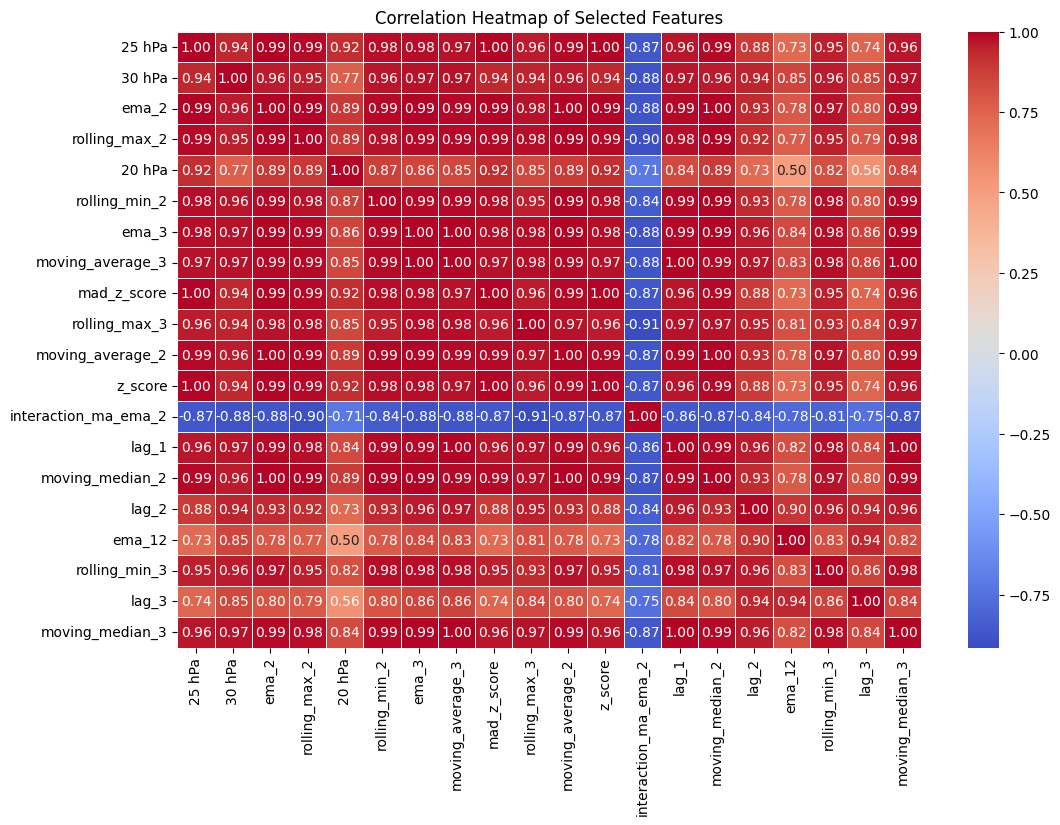

In [12]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [13]:
def prepare_time_series_data(data, time_steps=28, test_size=0.3, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=False)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(227, 28, 20) (227,)

Testing set shapes:
(98, 28, 20) (98,)


In [14]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.5287 - mae: 1.0617 - r_squared: -80.9605
Epoch 1: val_loss improved from inf to 0.92416, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - loss: 1.4871 - mae: 1.0475 - r_squared: -77.9050 - val_loss: 0.9242 - val_mae: 0.8749 - val_r_squared: -41.8490
Epoch 2/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8817 - mae: 0.8377 - r_squared: -69.1149
Epoch 2: val_loss improved from 0.92416 to 0.59022, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.8334 - mae: 0.8217 - r_squared: -65.7052 - val_loss: 0.5902 - val_mae: 0.6968 - val_r_squared: -41.4351
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5937 - mae: 0.6937 - r_squared: -74.5643
Epoch 3: val_loss improved from 0.59022 to 0.45448, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.5600 - mae: 0.6724 - r_squared: -70.0330 - val_loss: 0.4545 - val_mae: 0.5999 - val_r_squared: -43.5698
Epoch 4/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3910 - mae: 0.5362 - r_squared: -84.2433
Epoch 4: val_loss improved from 0.45448 to 0.33776, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.3950 - mae: 0.5436 - r_squared: -76.8880 - val_loss: 0.3378 - val_mae: 0.5038 - val_r_squared: -46.9145
Epoch 5/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3482 - mae: 0.5072 - r_squared: -92.4123
Epoch 5: val_loss improved from 0.33776 to 0.24422, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2889 - mae: 0.4534 - r_squared: -86.0092 - val_loss: 0.2442 - val_mae: 0.4160 - val_r_squared: -50.6765
Epoch 6/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1804 - mae: 0.3511 - r_squared: -108.3001
Epoch 6: val_loss improved from 0.24422 to 0.19748, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1773 - mae: 0.3460 - r_squared: -97.6692 - val_loss: 0.1975 - val_mae: 0.3347 - val_r_squared: -56.1638
Epoch 7/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.1405 - mae: 0.2704 - r_squared: -123.4626
Epoch 7: val_loss did not improve from 0.19748
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1457 - mae: 0.2798 - r_squared: -112.6881 - val_loss: 0.2179 - val_mae: 0.3416 - val_r_squared: -62.5977
Epoch 8/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1617 - mae: 0.2943 - r_squared: -133.0350
Epoch 8: val_loss improved from 0.19748 to 0.16774, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1515 - mae: 0.2962 - r_squared: -120.2452 - val_loss: 0.1677 - val_mae: 0.3081 - val_r_squared: -60.4565
Epoch 9/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1370 - mae: 0.2751 - r_squared: -126.4103
Epoch 9: val_loss improved from 0.16774 to 0.15251, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1180 - mae: 0.2594 - r_squared: -113.4565 - val_loss: 0.1525 - val_mae: 0.2988 - val_r_squared: -58.1011
Epoch 10/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1021 - mae: 0.2361 - r_squared: -120.9838
Epoch 10: val_loss improved from 0.15251 to 0.14929, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1020 - mae: 0.2359 - r_squared: -108.0975 - val_loss: 0.1493 - val_mae: 0.2872 - val_r_squared: -57.2170
Epoch 11/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1353 - mae: 0.2680 - r_squared: -111.8633
Epoch 11: val_loss improved from 0.14929 to 0.14703, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1068 - mae: 0.2379 - r_squared: -103.6221 - val_loss: 0.1470 - val_mae: 0.2816 - val_r_squared: -57.3300
Epoch 12/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0931 - mae: 0.2236 - r_squared: -114.9226
Epoch 12: val_loss improved from 0.14703 to 0.14052, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0921 - mae: 0.2213 - r_squared: -104.6411 - val_loss: 0.1405 - val_mae: 0.2765 - val_r_squared: -57.9695
Epoch 13/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0858 - mae: 0.2149 - r_squared: -113.4174
Epoch 13: val_loss improved from 0.14052 to 0.13402, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0837 - mae: 0.2113 - r_squared: -104.5385 - val_loss: 0.1340 - val_mae: 0.2704 - val_r_squared: -59.3432
Epoch 14/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0781 - mae: 0.2192 - r_squared: -116.4493
Epoch 14: val_loss did not improve from 0.13402
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0749 - mae: 0.2122 - r_squared: -108.0663 - val_loss: 0.1346 - val_mae: 0.2701 - val_r_squared: -60.9158
Epoch 15/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0584 - mae: 0.1941 - r_squared: -118.2683
Epoch 15: val_loss did not improve from 0.13402
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0682 - mae: 0.2064 - r_squared: -110.9862 - val_loss: 0.1367 - val_mae: 0.2605 - val_r_squared: -62.9720
Epoch 16/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0732 - mae: 0.2196 - r_squared: -125.4694
Epoch 16: val_loss improved from 0.13402 to 0.13239, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0711 - mae: 0.2092 - r_squared: -115.3431 - val_loss: 0.1324 - val_mae: 0.2527 - val_r_squared: -62.6239
Epoch 17/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0511 - mae: 0.1700 - r_squared: -123.2170
Epoch 17: val_loss improved from 0.13239 to 0.12956, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0589 - mae: 0.1842 - r_squared: -113.3668 - val_loss: 0.1296 - val_mae: 0.2587 - val_r_squared: -61.1002
Epoch 18/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0437 - mae: 0.1654 - r_squared: -125.4202
Epoch 18: val_loss improved from 0.12956 to 0.12692, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0560 - mae: 0.1848 - r_squared: -111.7636 - val_loss: 0.1269 - val_mae: 0.2517 - val_r_squared: -60.5629
Epoch 19/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0617 - mae: 0.1888 - r_squared: -122.2893
Epoch 19: val_loss did not improve from 0.12692
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0571 - mae: 0.1860 - r_squared: -110.1336 - val_loss: 0.1299 - val_mae: 0.2580 - val_r_squared: -59.8677
Epoch 20/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0474 - mae: 0.1717 - r_squared: -120.5030
Epoch 20: val_loss did not improve from 0.12692
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0515 - mae: 0.1791 - r_squared: -109.2697 - val_loss: 0.1314 - val_mae: 0.2549 - val_r_squared: -61.1071
Epoch 21/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0472 - mae: 0.1662 - r_squared: -123.1395
Epoch 21: val_loss did not improve from 0.12692
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0529 - mae: 0.1764 - r_squared: -111.4

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0436 - mae: 0.1535 - r_squared: -113.7819 - val_loss: 0.1251 - val_mae: 0.2390 - val_r_squared: -62.7622
Epoch 28/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0462 - mae: 0.1653 - r_squared: -120.9738
Epoch 28: val_loss improved from 0.12510 to 0.12491, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0449 - mae: 0.1606 - r_squared: -112.0730 - val_loss: 0.1249 - val_mae: 0.2439 - val_r_squared: -61.9558
Epoch 29/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0433 - mae: 0.1506 - r_squared: -124.3879
Epoch 29: val_loss did not improve from 0.12491
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0456 - mae: 0.1607 - r_squared: -112.9615 - val_loss: 0.1309 - val_mae: 0.2465 - val_r_squared: -63.0707
Epoch 30/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0458 - mae: 0.1593 - r_squared: -124.1566
Epoch 30: val_loss improved from 0.12491 to 0.12369, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0445 - mae: 0.1567 - r_squared: -113.5481 - val_loss: 0.1237 - val_mae: 0.2392 - val_r_squared: -61.7788
Epoch 31/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0510 - mae: 0.1632 - r_squared: -125.1290
Epoch 31: val_loss did not improve from 0.12369
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0452 - mae: 0.1581 - r_squared: -112.2346 - val_loss: 0.1247 - val_mae: 0.2384 - val_r_squared: -61.9279
Epoch 32/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0444 - mae: 0.1626 - r_squared: -125.3779
Epoch 32: val_loss did not improve from 0.12369
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0430 - mae: 0.1560 - r_squared: -112.8645 - val_loss: 0.1248 - val_mae: 0.2366 - val_r_squared: -62.7865
Epoch 33/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0488 - mae: 0.1686 - r_squared: -125.1216
Epoch 33: val_loss improved from 0.12369 to 0.12200, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0441 - mae: 0.1561 - r_squared: -113.4694 - val_loss: 0.1220 - val_mae: 0.2336 - val_r_squared: -62.7429
Epoch 34/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0479 - mae: 0.1607 - r_squared: -124.1338
Epoch 34: val_loss did not improve from 0.12200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0450 - mae: 0.1579 - r_squared: -113.6813 - val_loss: 0.1237 - val_mae: 0.2347 - val_r_squared: -63.2744
Epoch 35/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0356 - mae: 0.1416 - r_squared: -128.2378
Epoch 35: val_loss improved from 0.12200 to 0.12164, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0383 - mae: 0.1439 - r_squared: -115.1655 - val_loss: 0.1216 - val_mae: 0.2324 - val_r_squared: -62.3588
Epoch 36/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0330 - mae: 0.1346 - r_squared: -124.1354
Epoch 36: val_loss did not improve from 0.12164
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0393 - mae: 0.1479 - r_squared: -112.8558 - val_loss: 0.1249 - val_mae: 0.2380 - val_r_squared: -64.5310
Epoch 37/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0398 - mae: 0.1473 - r_squared: -124.7810
Epoch 37: val_loss improved from 0.12164 to 0.12113, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0452 - mae: 0.1597 - r_squared: -116.4087 - val_loss: 0.1211 - val_mae: 0.2306 - val_r_squared: -62.7431
Epoch 38/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0276 - mae: 0.1234 - r_squared: -126.0591
Epoch 38: val_loss improved from 0.12113 to 0.11920, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0368 - mae: 0.1412 - r_squared: -112.5790 - val_loss: 0.1192 - val_mae: 0.2307 - val_r_squared: -60.5886
Epoch 39/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0403 - mae: 0.1598 - r_squared: -117.7210
Epoch 39: val_loss did not improve from 0.11920
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0415 - mae: 0.1573 - r_squared: -109.1562 - val_loss: 0.1227 - val_mae: 0.2330 - val_r_squared: -62.9172
Epoch 40/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.0374 - mae: 0.1443 - r_squared: -126.5655
Epoch 40: val_loss improved from 0.11920 to 0.11869, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0411 - mae: 0.1517 - r_squared: -114.2191 - val_loss: 0.1187 - val_mae: 0.2248 - val_r_squared: -62.9352
Epoch 41/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0397 - mae: 0.1458 - r_squared: -127.2394
Epoch 41: val_loss improved from 0.11869 to 0.11819, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.0409 - mae: 0.1494 - r_squared: -114.0704 - val_loss: 0.1182 - val_mae: 0.2239 - val_r_squared: -63.1550
Epoch 42/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0412 - mae: 0.1537 - r_squared: -127.5070
Epoch 42: val_loss did not improve from 0.11819
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0400 - mae: 0.1496 - r_squared: -114.9815 - val_loss: 0.1248 - val_mae: 0.2370 - val_r_squared: -63.4653
Epoch 43/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0388 - mae: 0.1408 - r_squared: -124.0324
Epoch 43: val_loss did not improve from 0.11819
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0394 - mae: 0.1444 - r_squared: -113.0250 - val_loss: 0.1191 - val_mae: 0.2256 - val_r_squared: -61.3569
Epoch 44/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0388 - mae: 0.1507 - r_squared: -119.9164
Epoch 44: val_loss did not improve from 0.11819
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0397 - mae: 0.1501 - r_squared: -110

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0366 - mae: 0.1415 - r_squared: -114.3469 - val_loss: 0.1172 - val_mae: 0.2199 - val_r_squared: -62.7430
Epoch 52/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0423 - mae: 0.1537 - r_squared: -121.9338
Epoch 52: val_loss improved from 0.11720 to 0.11710, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0394 - mae: 0.1462 - r_squared: -112.9650 - val_loss: 0.1171 - val_mae: 0.2195 - val_r_squared: -63.3983
Epoch 53/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0358 - mae: 0.1386 - r_squared: -125.5704
Epoch 53: val_loss did not improve from 0.11710
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0360 - mae: 0.1379 - r_squared: -114.0313 - val_loss: 0.1217 - val_mae: 0.2280 - val_r_squared: -62.6377
Epoch 54/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0362 - mae: 0.1357 - r_squared: -122.5398
Epoch 54: val_loss did not improve from 0.11710
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0366 - mae: 0.1399 - r_squared: -112.5126 - val_loss: 0.1181 - val_mae: 0.2224 - val_r_squared: -62.6439
Epoch 55/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0349 - mae: 0.1288 - r_squared: -123.4099
Epoch 55: val_loss improved from 0.11710 to 0.11544, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0374 - mae: 0.1376 - r_squared: -112.0346 - val_loss: 0.1154 - val_mae: 0.2181 - val_r_squared: -63.2814
Epoch 56/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0407 - mae: 0.1512 - r_squared: -122.2882
Epoch 56: val_loss did not improve from 0.11544
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0361 - mae: 0.1382 - r_squared: -113.6276 - val_loss: 0.1245 - val_mae: 0.2334 - val_r_squared: -64.4591
Epoch 57/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0390 - mae: 0.1545 - r_squared: -126.6075
Epoch 57: val_loss did not improve from 0.11544
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0383 - mae: 0.1488 - r_squared: -115.1167 - val_loss: 0.1188 - val_mae: 0.2191 - val_r_squared: -62.0518
Epoch 58/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0451 - mae: 0.1546 - r_squared: -122.6957
Epoch 58: val_loss improved from 0.11544 to 0.11526, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0376 - mae: 0.1431 - r_squared: -111.5636 - val_loss: 0.1153 - val_mae: 0.2156 - val_r_squared: -63.1030
Epoch 59/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0330 - mae: 0.1371 - r_squared: -125.3816
Epoch 59: val_loss did not improve from 0.11526
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0368 - mae: 0.1421 - r_squared: -115.3108 - val_loss: 0.1188 - val_mae: 0.2254 - val_r_squared: -64.3169
Epoch 60/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0293 - mae: 0.1242 - r_squared: -124.3995
Epoch 60: val_loss did not improve from 0.11526
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0336 - mae: 0.1336 - r_squared: -114.0517 - val_loss: 0.1157 - val_mae: 0.2196 - val_r_squared: -61.7835
Epoch 61/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0366 - mae: 0.1346 - r_squared: -122.1034
Epoch 61: val_loss did not improve from 0.11526
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0378 - mae: 0.1409 - r_squared: -110.86

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0339 - mae: 0.1321 - r_squared: -112.5681 - val_loss: 0.1137 - val_mae: 0.2153 - val_r_squared: -64.3489
Epoch 63/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0416 - mae: 0.1454 - r_squared: -126.8301
Epoch 63: val_loss did not improve from 0.11365
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0375 - mae: 0.1391 - r_squared: -115.8905 - val_loss: 0.1143 - val_mae: 0.2145 - val_r_squared: -63.2511
Epoch 64/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0373 - mae: 0.1413 - r_squared: -125.6791
Epoch 64: val_loss did not improve from 0.11365
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0346 - mae: 0.1343 - r_squared: -114.0202 - val_loss: 0.1174 - val_mae: 0.2184 - val_r_squared: -62.6578
Epoch 65/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0357 - mae: 0.1334 - r_squared: -124.6860
Epoch 65: val_loss did not improve from 0.11365
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0347 - mae: 0.1338 - r_squared: -11

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0332 - mae: 0.1346 - r_squared: -112.4277 - val_loss: 0.1131 - val_mae: 0.2117 - val_r_squared: -63.8640
Epoch 76/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0380 - mae: 0.1426 - r_squared: -124.6781
Epoch 76: val_loss did not improve from 0.11312
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0340 - mae: 0.1336 - r_squared: -114.8102 - val_loss: 0.1170 - val_mae: 0.2234 - val_r_squared: -65.1157
Epoch 77/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0311 - mae: 0.1340 - r_squared: -125.9267
Epoch 77: val_loss did not improve from 0.11312
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0319 - mae: 0.1324 - r_squared: -115.5090 - val_loss: 0.1140 - val_mae: 0.2135 - val_r_squared: -62.2665
Epoch 78/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0360 - mae: 0.1381 - r_squared: -121.8813
Epoch 78: val_loss improved from 0.11312 to 0.11092, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0321 - mae: 0.1319 - r_squared: -110.8015 - val_loss: 0.1109 - val_mae: 0.2076 - val_r_squared: -61.9781
Epoch 79/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0242 - mae: 0.1218 - r_squared: -121.4150
Epoch 79: val_loss did not improve from 0.11092
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0305 - mae: 0.1292 - r_squared: -111.5845 - val_loss: 0.1130 - val_mae: 0.2153 - val_r_squared: -64.1056
Epoch 80/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0342 - mae: 0.1350 - r_squared: -124.8956
Epoch 80: val_loss did not improve from 0.11092
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0321 - mae: 0.1314 - r_squared: -114.2346 - val_loss: 0.1121 - val_mae: 0.2091 - val_r_squared: -62.5771
Epoch 81/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0181 - mae: 0.1021 - r_squared: -124.8309
Epoch 81: val_loss did not improve from 0.11092
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0285 - mae: 0.1234 - r_squared: -112.95

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0353 - mae: 0.1417 - r_squared: -118.6325 - val_loss: 0.1102 - val_mae: 0.2088 - val_r_squared: -61.7253
Epoch 92/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0313 - mae: 0.1373 - r_squared: -120.1978
Epoch 92: val_loss did not improve from 0.11022
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0327 - mae: 0.1390 - r_squared: -110.1499 - val_loss: 0.1143 - val_mae: 0.2191 - val_r_squared: -62.8002
Epoch 93/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0330 - mae: 0.1276 - r_squared: -121.6942
Epoch 93: val_loss did not improve from 0.11022
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0307 - mae: 0.1265 - r_squared: -111.9229 - val_loss: 0.1114 - val_mae: 0.2127 - val_r_squared: -63.4887
Epoch 94/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0240 - mae: 0.1126 - r_squared: -123.7600
Epoch 94: val_loss did not improve from 0.11022
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0276 - mae: 0.1209 - r_squared: -113.

In [15]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.9996 - mae: 0.8982 - r_squared: -67.0439
Epoch 1: val_loss improved from inf to 0.62023, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.9947 - mae: 0.8962 - r_squared: -65.2602 - val_loss: 0.6202 - val_mae: 0.6998 - val_r_squared: -41.0747
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.5645 - mae: 0.6387 - r_squared: -76.1766
Epoch 2: val_loss improved from 0.62023 to 0.37607, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step - loss: 0.5528 - mae: 0.6305 - r_squared: -74.2270 - val_loss: 0.3761 - val_mae: 0.4881 - val_r_squared: -50.6149
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.3103 - mae: 0.4057 - r_squared: -100.7133
Epoch 3: val_loss improved from 0.37607 to 0.35529, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - loss: 0.3063 - mae: 0.4032 - r_squared: -98.4725 - val_loss: 0.3553 - val_mae: 0.4192 - val_r_squared: -63.6596
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.3596 - mae: 0.4297 - r_squared: -131.5014
Epoch 4: val_loss did not improve from 0.35529
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.3538 - mae: 0.4274 - r_squared: -126.7069 - val_loss: 0.3583 - val_mae: 0.4284 - val_r_squared: -63.8354
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2911 - mae: 0.3981 - r_squared: -126.4594
Epoch 5: val_loss improved from 0.35529 to 0.33155, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step - loss: 0.2893 - mae: 0.3983 - r_squared: -122.1024 - val_loss: 0.3315 - val_mae: 0.3902 - val_r_squared: -58.4690
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3098 - mae: 0.4059 - r_squared: -114.2358 
Epoch 6: val_loss improved from 0.33155 to 0.31924, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step - loss: 0.3023 - mae: 0.3986 - r_squared: -110.6211 - val_loss: 0.3192 - val_mae: 0.3893 - val_r_squared: -53.8813
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2381 - mae: 0.3507 - r_squared: -109.2644
Epoch 7: val_loss improved from 0.31924 to 0.31159, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step - loss: 0.2382 - mae: 0.3507 - r_squared: -105.5868 - val_loss: 0.3116 - val_mae: 0.4118 - val_r_squared: -51.4151
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2227 - mae: 0.3546 - r_squared: -102.0692 
Epoch 8: val_loss improved from 0.31159 to 0.29354, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - loss: 0.2221 - mae: 0.3536 - r_squared: -98.6929 - val_loss: 0.2935 - val_mae: 0.4065 - val_r_squared: -51.6501
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2068 - mae: 0.3281 - r_squared: -104.4346
Epoch 9: val_loss improved from 0.29354 to 0.27526, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - loss: 0.2051 - mae: 0.3276 - r_squared: -101.1844 - val_loss: 0.2753 - val_mae: 0.3822 - val_r_squared: -53.4668
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2258 - mae: 0.3249 - r_squared: -108.2882
Epoch 10: val_loss improved from 0.27526 to 0.26242, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step - loss: 0.2216 - mae: 0.3232 - r_squared: -105.2258 - val_loss: 0.2624 - val_mae: 0.3600 - val_r_squared: -54.9720
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2063 - mae: 0.3243 - r_squared: -107.2591
Epoch 11: val_loss improved from 0.26242 to 0.25251, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - loss: 0.2046 - mae: 0.3222 - r_squared: -103.9311 - val_loss: 0.2525 - val_mae: 0.3491 - val_r_squared: -55.2404
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2419 - mae: 0.3636 - r_squared: -105.2454
Epoch 12: val_loss improved from 0.25251 to 0.24365, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step - loss: 0.2358 - mae: 0.3594 - r_squared: -102.8127 - val_loss: 0.2436 - val_mae: 0.3386 - val_r_squared: -56.0235
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1867 - mae: 0.3037 - r_squared: -111.4727
Epoch 13: val_loss improved from 0.24365 to 0.23668, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step - loss: 0.1844 - mae: 0.3046 - r_squared: -107.5583 - val_loss: 0.2367 - val_mae: 0.3272 - val_r_squared: -56.0659
Epoch 14/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1747 - mae: 0.2942 - r_squared: -106.6197
Epoch 14: val_loss improved from 0.23668 to 0.23140, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - loss: 0.1727 - mae: 0.2923 - r_squared: -103.6650 - val_loss: 0.2314 - val_mae: 0.3190 - val_r_squared: -57.9959
Epoch 15/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1247 - mae: 0.2735 - r_squared: -112.6429
Epoch 15: val_loss improved from 0.23140 to 0.21893, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 494ms/step - loss: 0.1280 - mae: 0.2751 - r_squared: -109.4634 - val_loss: 0.2189 - val_mae: 0.3152 - val_r_squared: -58.6079
Epoch 16/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1507 - mae: 0.2764 - r_squared: -110.3888 
Epoch 16: val_loss did not improve from 0.21893
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.1502 - mae: 0.2782 - r_squared: -106.5138 - val_loss: 0.2248 - val_mae: 0.3152 - val_r_squared: -59.2641
Epoch 17/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1213 - mae: 0.2653 - r_squared: -112.8178
Epoch 17: val_loss did not improve from 0.21893
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.1240 - mae: 0.2680 - r_squared: -109.2823 - val_loss: 0.2764 - val_mae: 0.3449 - val_r_squared: -62.9451
Epoch 18/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1050 - mae: 0.2487 - r_squared: -113.5351 
Epoch 18: val_loss did not improve from 0.21893
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.1082 - mae: 0.2518 - r_squared: -1

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - loss: 0.1161 - mae: 0.2675 - r_squared: -111.9776 - val_loss: 0.2010 - val_mae: 0.2924 - val_r_squared: -61.3876
Epoch 20/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1259 - mae: 0.2822 - r_squared: -113.0915
Epoch 20: val_loss did not improve from 0.20097
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.1242 - mae: 0.2800 - r_squared: -109.4917 - val_loss: 0.2062 - val_mae: 0.2954 - val_r_squared: -62.0428
Epoch 21/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0961 - mae: 0.2484 - r_squared: -115.1184
Epoch 21: val_loss did not improve from 0.20097
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0972 - mae: 0.2489 - r_squared: -111.4453 - val_loss: 0.2345 - val_mae: 0.3187 - val_r_squared: -63.2815
Epoch 22/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1227 - mae: 0.2841 - r_squared: -117.7876
Epoch 22: val_loss did not improve from 0.20097
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1203 - mae: 0.2809 - r_squared: -114

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step - loss: 0.0754 - mae: 0.2110 - r_squared: -114.2936 - val_loss: 0.1824 - val_mae: 0.2973 - val_r_squared: -61.5237
Epoch 31/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0975 - mae: 0.2541 - r_squared: -111.5532
Epoch 31: val_loss did not improve from 0.18237
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0950 - mae: 0.2509 - r_squared: -107.9358 - val_loss: 0.2146 - val_mae: 0.3245 - val_r_squared: -63.1941
Epoch 32/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0770 - mae: 0.2240 - r_squared: -118.1921
Epoch 32: val_loss did not improve from 0.18237
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0761 - mae: 0.2215 - r_squared: -114.3545 - val_loss: 0.2208 - val_mae: 0.3277 - val_r_squared: -63.4949
Epoch 33/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0792 - mae: 0.2237 - r_squared: -113.6729
Epoch 33: val_loss did not improve from 0.18237
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - loss: 0.0794 - mae: 0.2238 - r_squared: -11

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step - loss: 0.0531 - mae: 0.1847 - r_squared: -110.4176 - val_loss: 0.1738 - val_mae: 0.2937 - val_r_squared: -58.5623
Epoch 63/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0605 - mae: 0.1936 - r_squared: -112.9557
Epoch 63: val_loss did not improve from 0.17382
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0593 - mae: 0.1919 - r_squared: -109.7081 - val_loss: 0.1892 - val_mae: 0.2914 - val_r_squared: -61.7916
Epoch 64/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0482 - mae: 0.1830 - r_squared: -118.1633
Epoch 64: val_loss did not improve from 0.17382
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0478 - mae: 0.1823 - r_squared: -114.4139 - val_loss: 0.2059 - val_mae: 0.3040 - val_r_squared: -63.9750
Epoch 65/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0435 - mae: 0.1653 - r_squared: -121.3356 
Epoch 65: val_loss did not improve from 0.17382
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.0442 - mae: 0.1662 - r_squared: -11

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - loss: 0.0407 - mae: 0.1568 - r_squared: -114.6420 - val_loss: 0.1728 - val_mae: 0.2807 - val_r_squared: -62.5352
Epoch 85/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0342 - mae: 0.1475 - r_squared: -118.2787
Epoch 85: val_loss did not improve from 0.17280
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0353 - mae: 0.1501 - r_squared: -114.5322 - val_loss: 0.1840 - val_mae: 0.2806 - val_r_squared: -64.3762
Epoch 86/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0420 - mae: 0.1651 - r_squared: -118.8975
Epoch 86: val_loss did not improve from 0.17280
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0419 - mae: 0.1648 - r_squared: -115.2497 - val_loss: 0.1974 - val_mae: 0.2926 - val_r_squared: -65.3309
Epoch 87/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0371 - mae: 0.1489 - r_squared: -119.6164
Epoch 87: val_loss improved from 0.17280 to 0.16984, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step - loss: 0.0371 - mae: 0.1495 - r_squared: -115.7629 - val_loss: 0.1698 - val_mae: 0.2699 - val_r_squared: -63.4733
Epoch 88/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0366 - mae: 0.1451 - r_squared: -118.1737 
Epoch 88: val_loss improved from 0.16984 to 0.16207, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - loss: 0.0371 - mae: 0.1461 - r_squared: -114.3757 - val_loss: 0.1621 - val_mae: 0.2640 - val_r_squared: -61.9991
Epoch 89/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0340 - mae: 0.1454 - r_squared: -115.6370 
Epoch 89: val_loss did not improve from 0.16207
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.0350 - mae: 0.1473 - r_squared: -112.0171 - val_loss: 0.1898 - val_mae: 0.2879 - val_r_squared: -62.3006
Epoch 90/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0332 - mae: 0.1466 - r_squared: -114.3635
Epoch 90: val_loss did not improve from 0.16207
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0333 - mae: 0.1467 - r_squared: -110.7766 - val_loss: 0.1907 - val_mae: 0.2885 - val_r_squared: -62.6000
Epoch 91/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0362 - mae: 0.1451 - r_squared: -114.1168
Epoch 91: val_loss did not improve from 0.16207
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0366 - mae: 0.1462 - r_squared: -11

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - loss: 0.0260 - mae: 0.1254 - r_squared: -113.8880 - val_loss: 0.1581 - val_mae: 0.2696 - val_r_squared: -61.1264
Epoch 159/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0269 - mae: 0.1315 - r_squared: -115.2163 
Epoch 159: val_loss did not improve from 0.15815
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 0.0267 - mae: 0.1307 - r_squared: -111.8549 - val_loss: 0.1663 - val_mae: 0.2679 - val_r_squared: -62.8862
Epoch 160/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0259 - mae: 0.1277 - r_squared: -119.1854 
Epoch 160: val_loss did not improve from 0.15815
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.0259 - mae: 0.1281 - r_squared: -115.1915 - val_loss: 0.1935 - val_mae: 0.2956 - val_r_squared: -64.4574
Epoch 161/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0284 - mae: 0.1350 - r_squared: -115.7546
Epoch 161: val_loss did not improve from 0.15815
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - loss: 0.0278 - mae: 0.1338 - r_squa

In [17]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


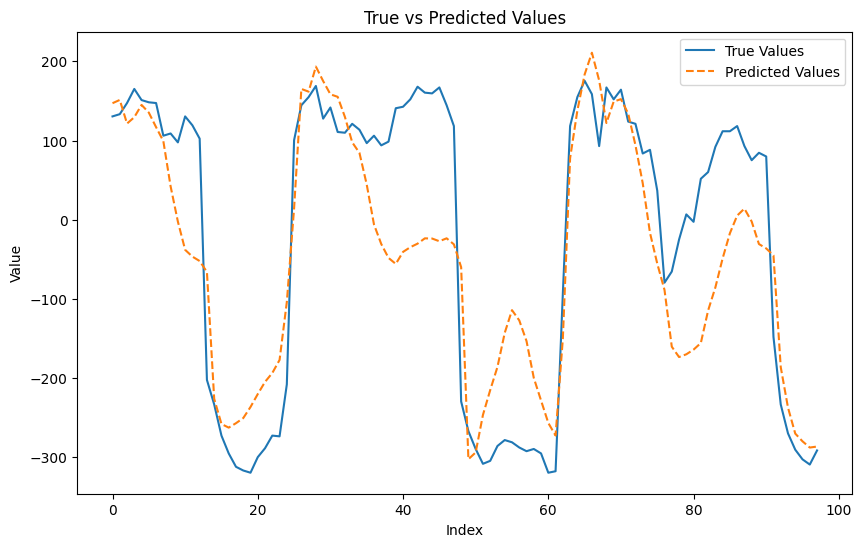

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


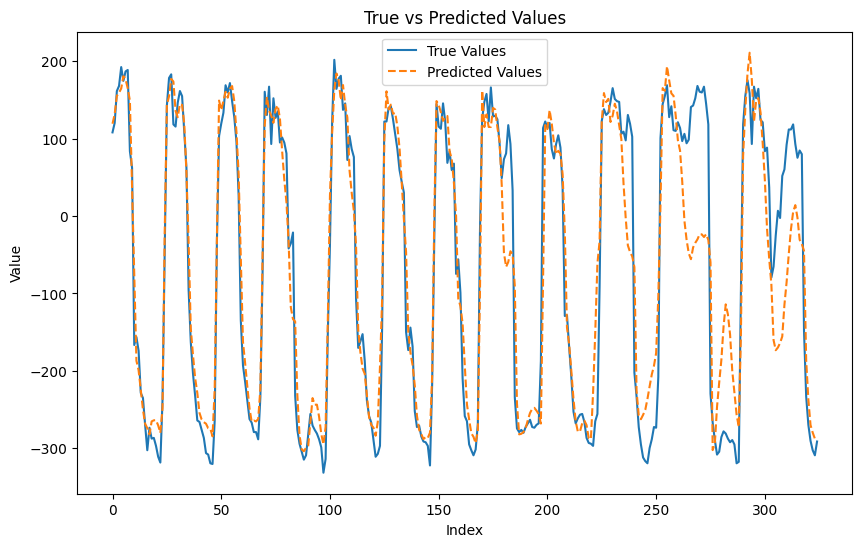

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


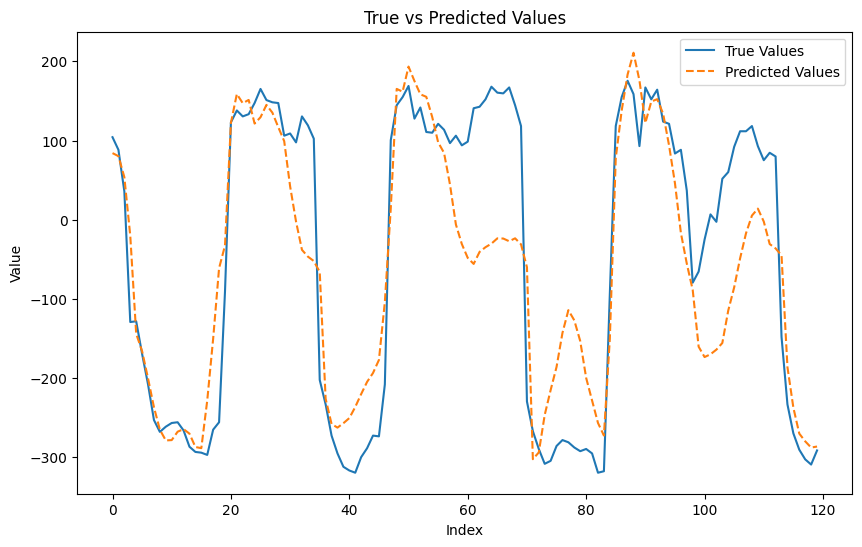

In [18]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 806ms/step


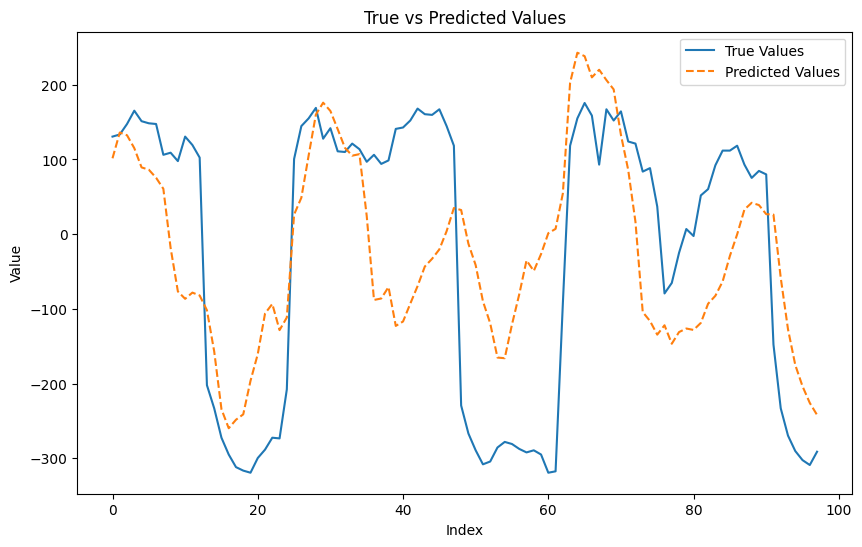

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


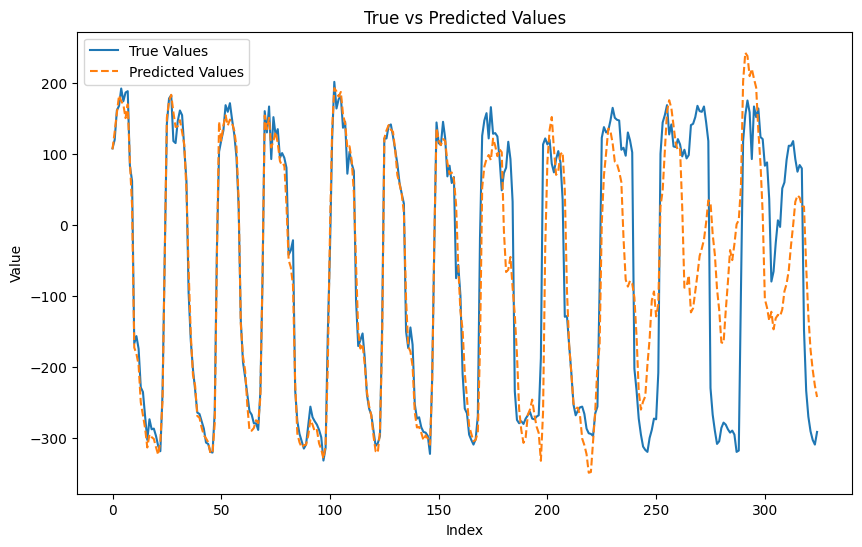

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


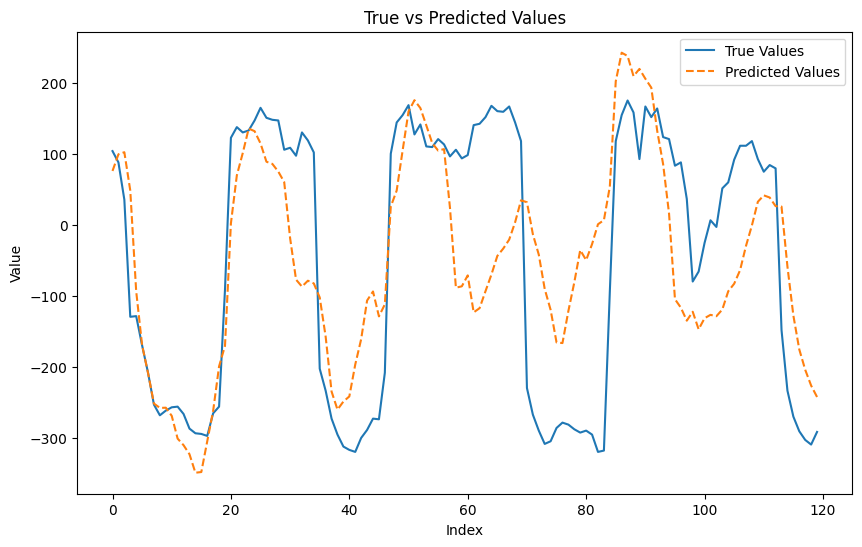

In [19]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [20]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


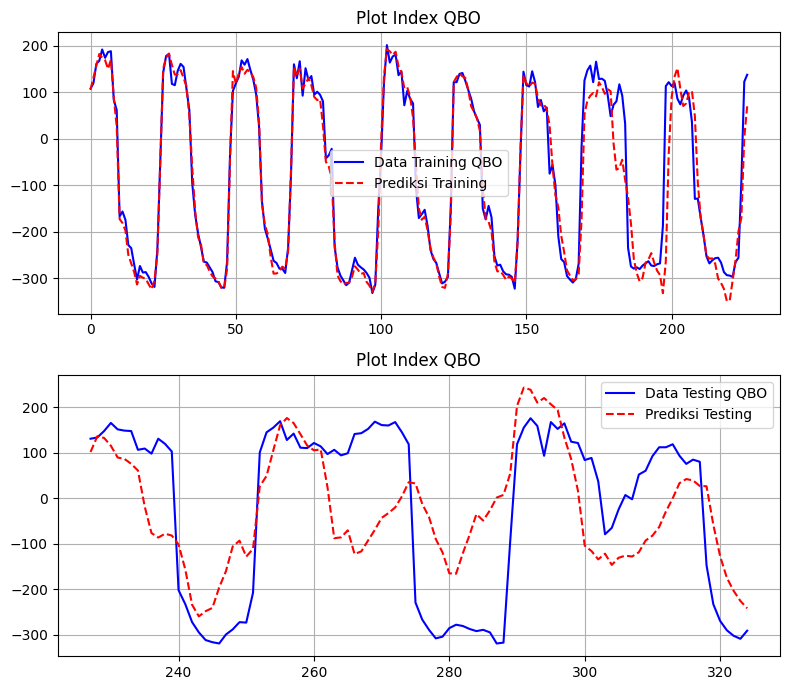

In [21]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_idx, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_idx, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [23]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [24]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.12954786312476352
RMSE:  0.35992758038911593
R-squared:  0.8706248907492018
MAE:  0.24486178136441084
Log Likelihood:  -191928.60735277415
MAPE:  161.22529782511774


In [25]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.22921321380309487
RMSE:  0.47876216830812235
R-squared:  0.7710924451996352
MAE:  0.29458089659917197
Log Likelihood:  -193655.87043518043
MAPE:  162.89853556671267


In [26]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.2994001589202794
RMSE:  0.5471747060311536
R-squared:  0.7035595895118351
MAE:  0.4409624771810758
Log Likelihood:  -16703.56923498836
MAPE:  156.02260739839122


In [27]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.6152239880638015
RMSE:  0.7843621536406519
R-squared:  0.3908578665372038
MAE:  0.6648083730541682
Log Likelihood:  -15734.796994342765
MAPE:  141.6406331587956


In [28]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [29]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  4610.302520522864
RMSE:  67.89920854121102
R-squared:  0.8706248897830063
MAE:  46.192406737439306
Log Likelihood:  -749472.814608257
MAPE:  67.7080447766853


In [30]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  8157.156944203417
RMSE:  90.31698037580429
R-squared:  0.7710924447981898
MAE:  55.571761351499504
Log Likelihood:  -1325836.6584563467
MAPE:  66.14051313772872


In [31]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  9318.755686416023
RMSE:  96.53370233455269
R-squared:  0.7431797659859276
MAE:  74.09656390940242
Log Likelihood:  -559235.613808946
MAPE:  132.2916618039243


In [32]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  18533.93978483327
RMSE:  136.1394130471895
R-squared:  0.4892139130032013
MAE:  110.06765968866786
Log Likelihood:  -1112146.6597139807
MAPE:  135.35879154089997


In [33]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  10654.944545427552
RMSE:  103.22279082367204
R-squared:  0.7035595893901965
MAE:  83.18618694624251
Log Likelihood:  -522182.33870220423
MAPE:  157.4944544089122
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  2000.7214708129254
RMSE:  44.729425111585385
R-squared:  0.9419762329408132
MAE:  30.22152476081951
Log Likelihood:  -227290.48598430454
MAPE:  28.945630906765306


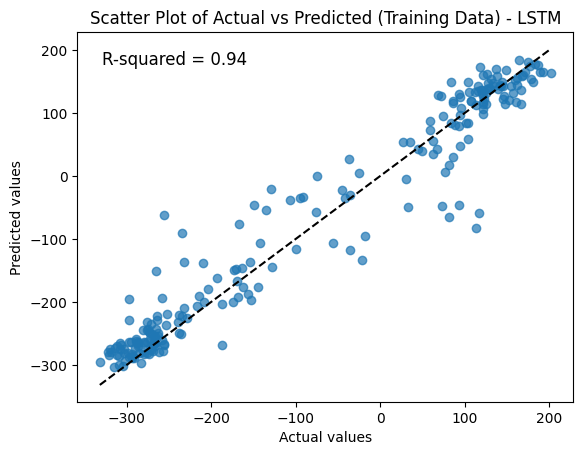

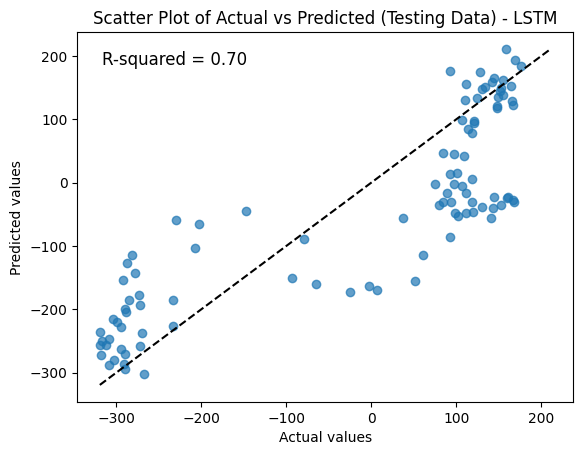

In [34]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [35]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  21894.368886754648
RMSE:  147.9674588778041
R-squared:  0.3908578617973827
MAE:  125.41401354091809
Log Likelihood:  -1072914.1314272317
MAPE:  158.12435777659047
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  2226.5544700376568
RMSE:  47.18638013280587
R-squared:  0.9354267548987902
MAE:  25.419599949433074
Log Likelihood:  -252922.53139631145
MAPE:  26.429426356925585


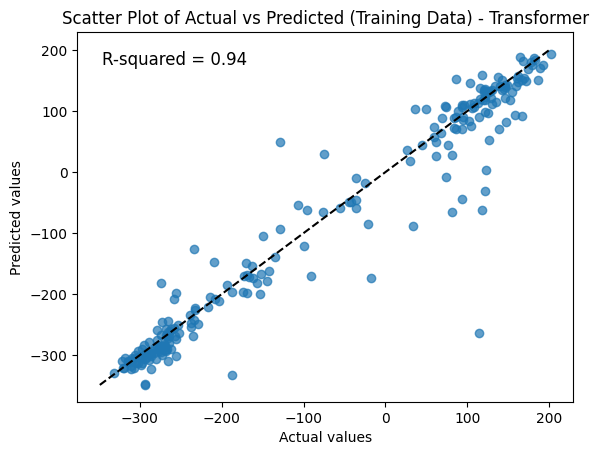

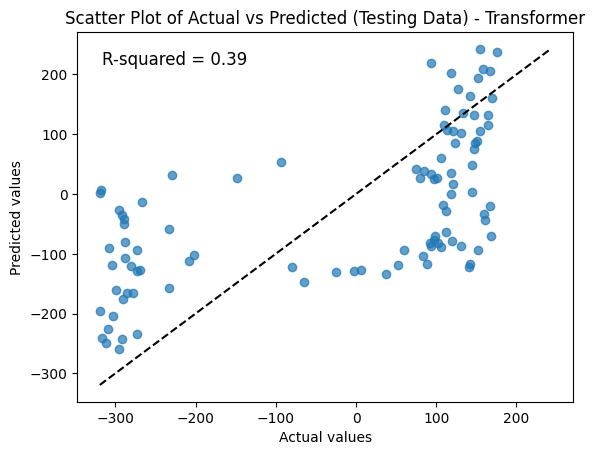

In [36]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

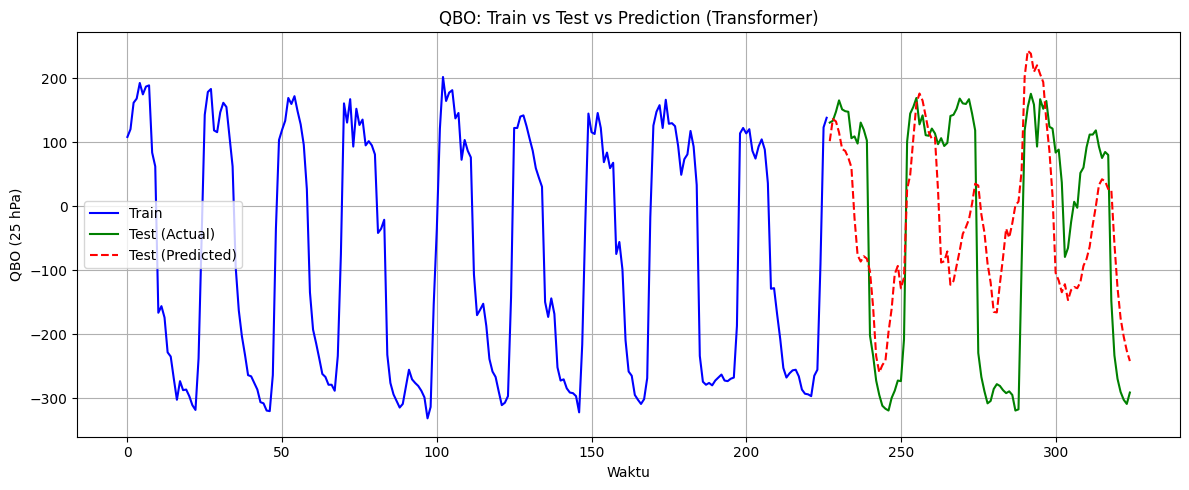

In [37]:
# Misal train_len = jumlah data train
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_idx, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

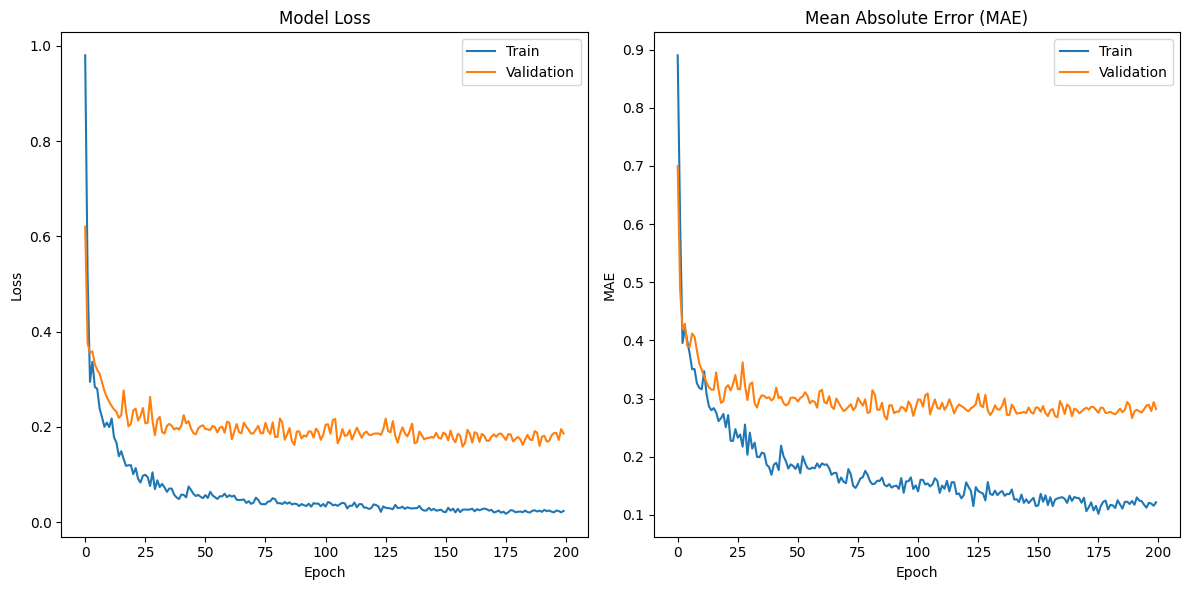

In [38]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [39]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

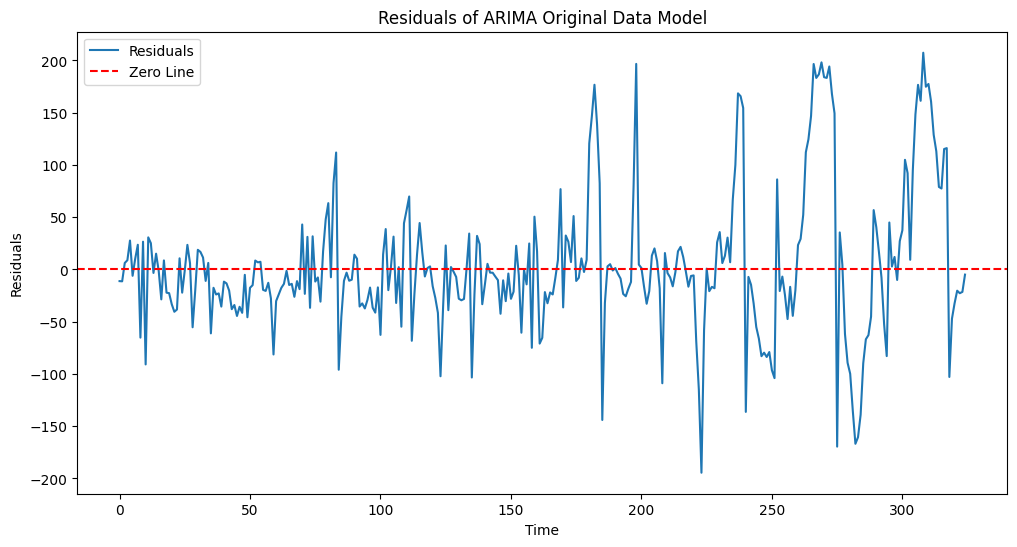

In [40]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

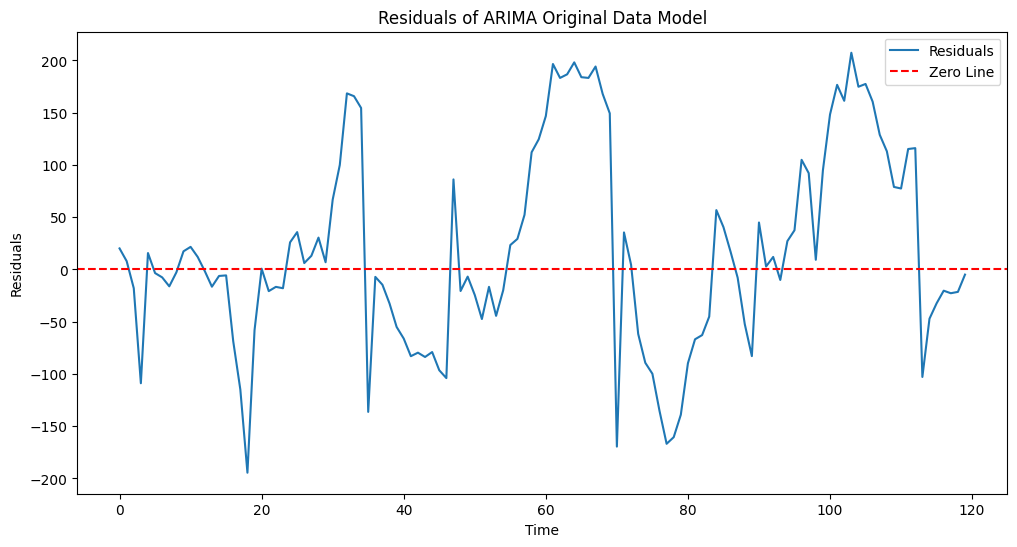

In [41]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [42]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

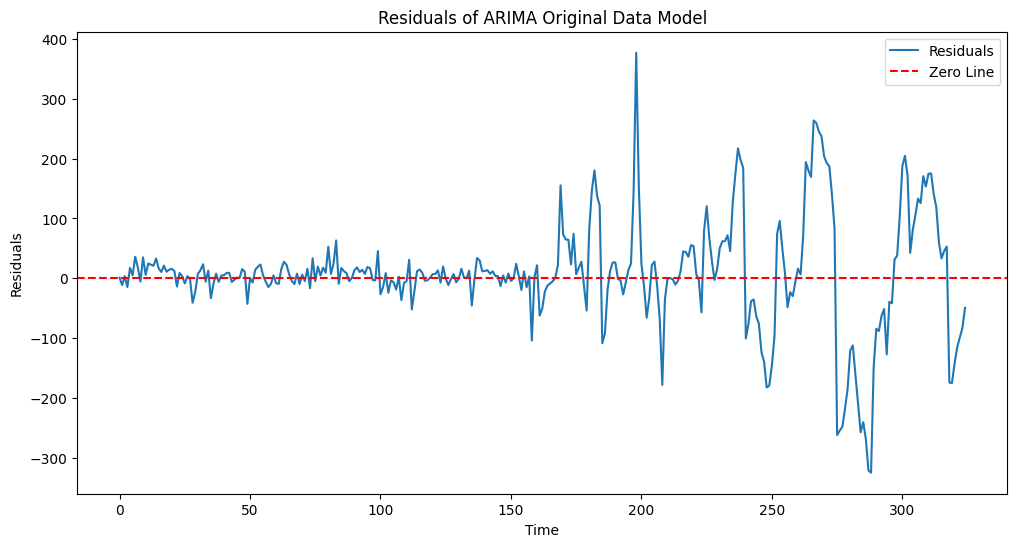

In [43]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

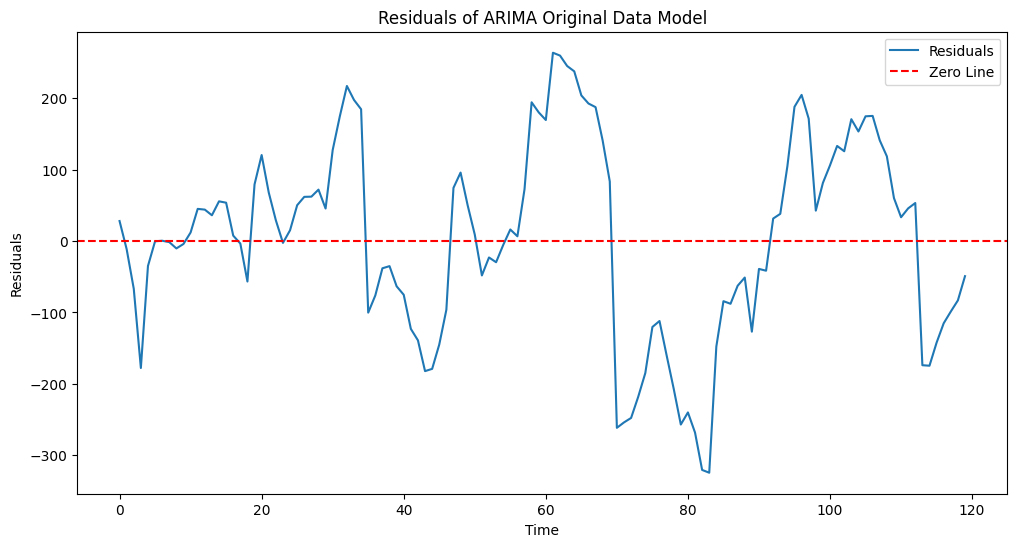

In [44]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [45]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9112250962641163
P-value: 6.476732905276788e-13
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

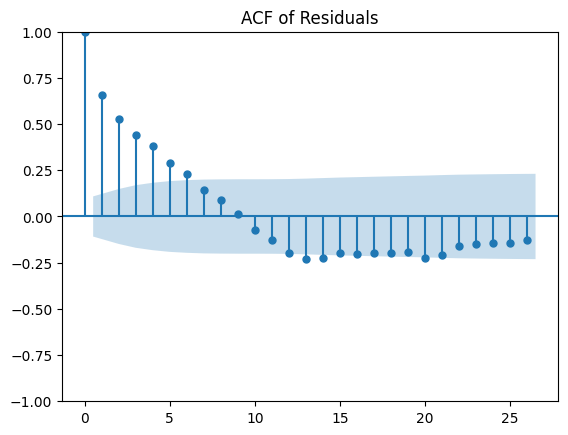

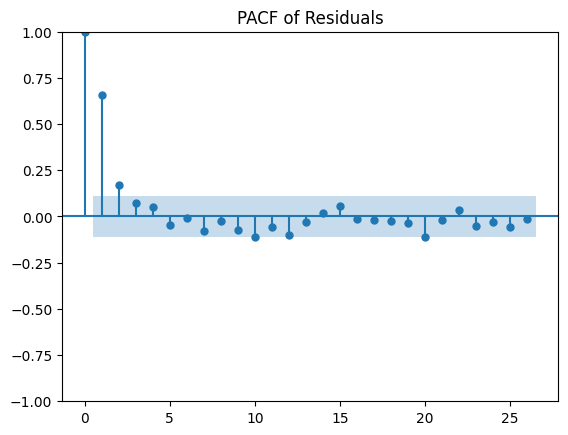

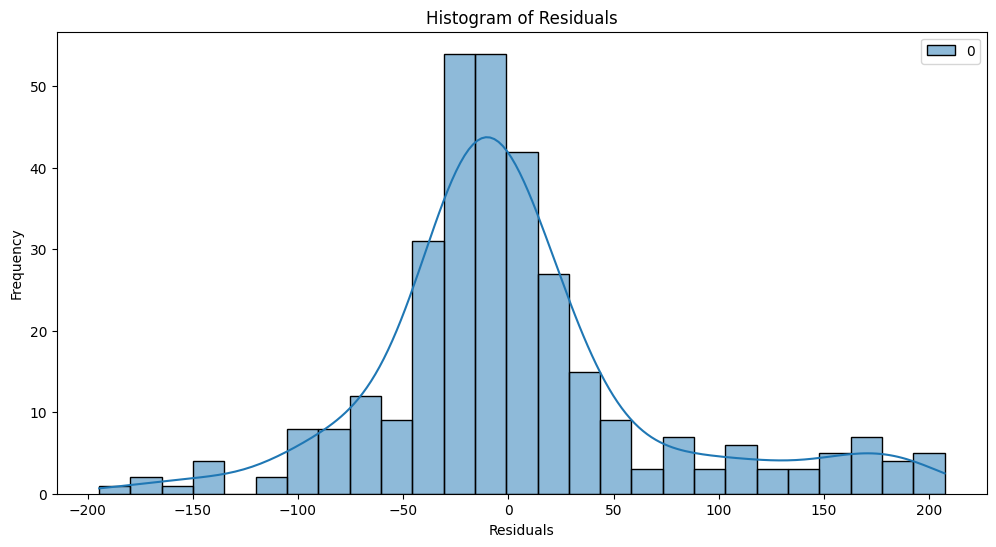

In [46]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9633832361810218
P-value: 0.0023883647915344188
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

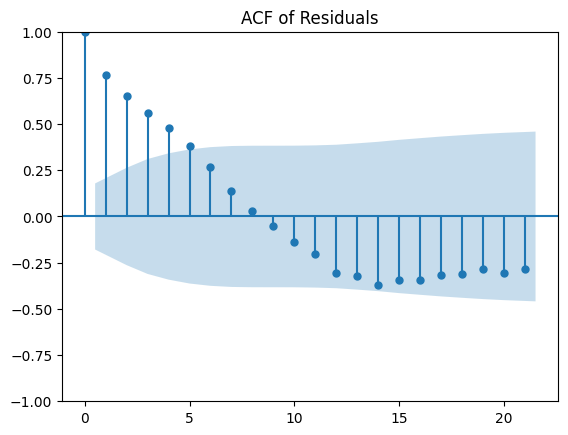

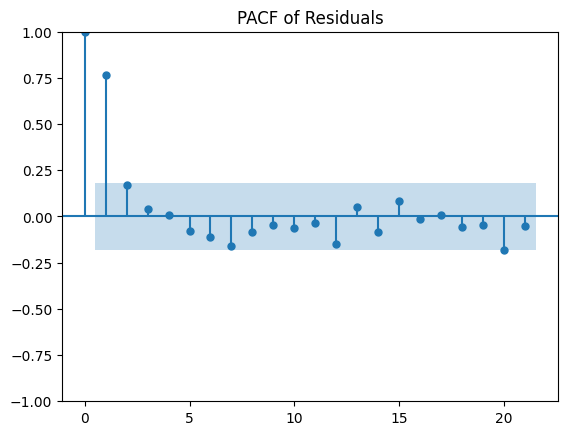

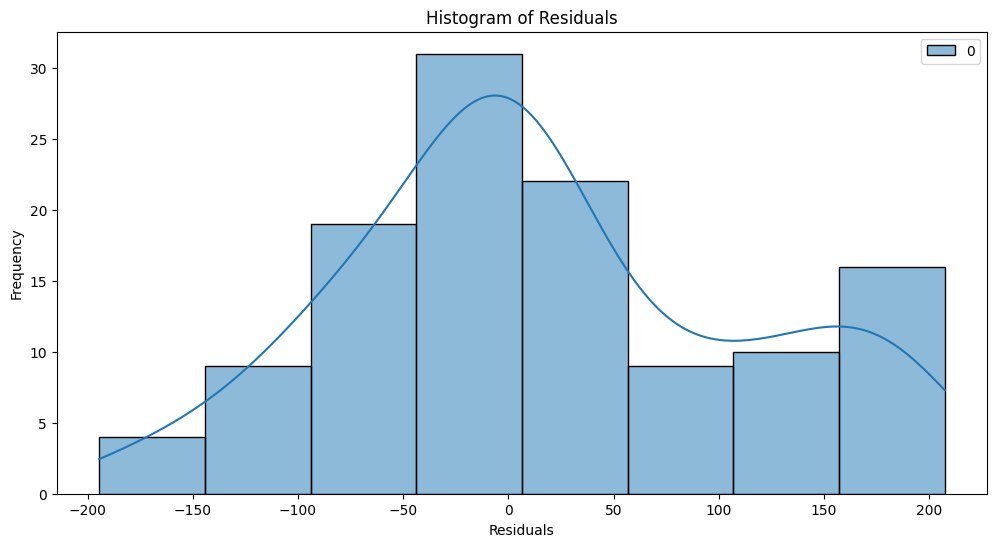

In [47]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8885283675103236
P-value: 1.162295093508841e-14
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

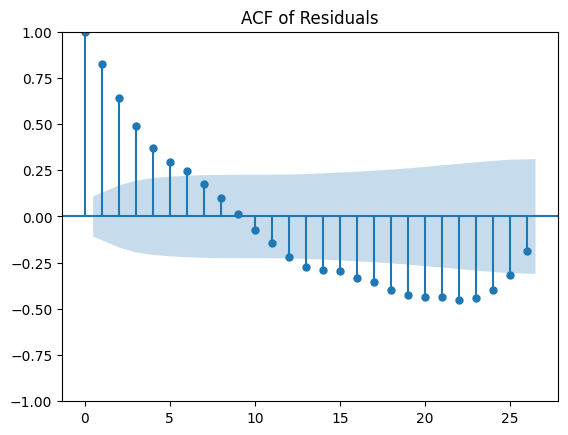

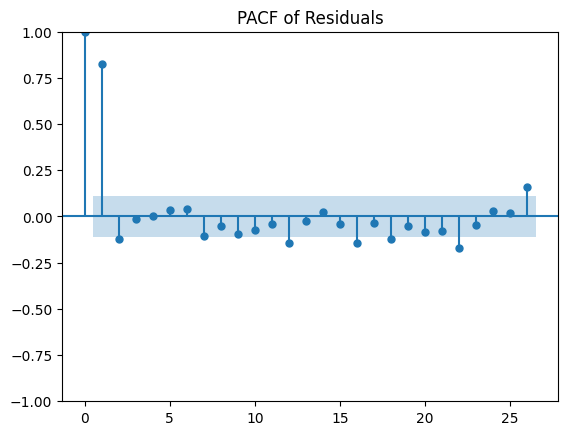

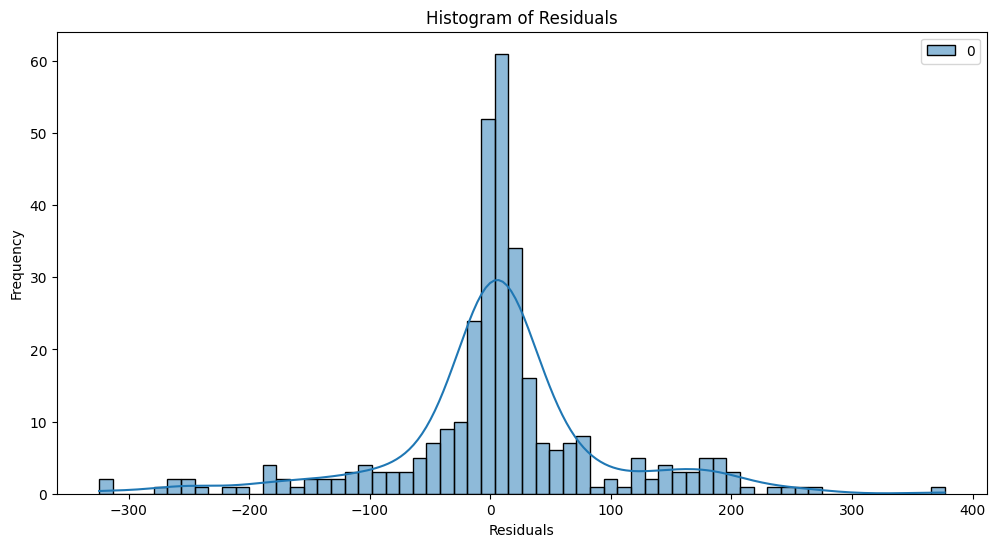

In [48]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9820399088594223
P-value: 0.11014581595346151
The residuals appear to be normally distributed.


<Figure size 1200x600 with 0 Axes>

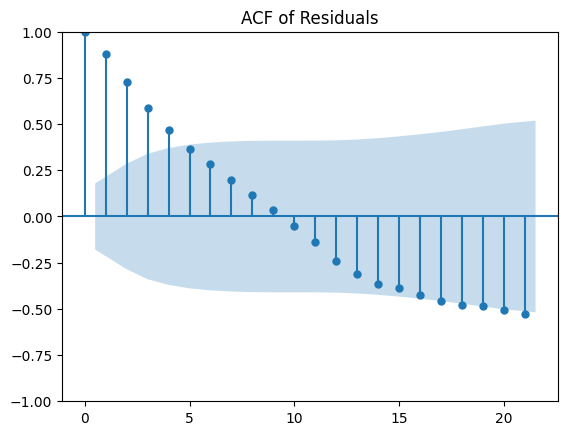

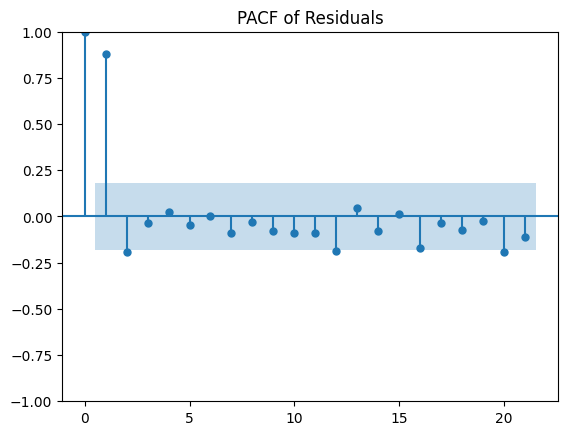

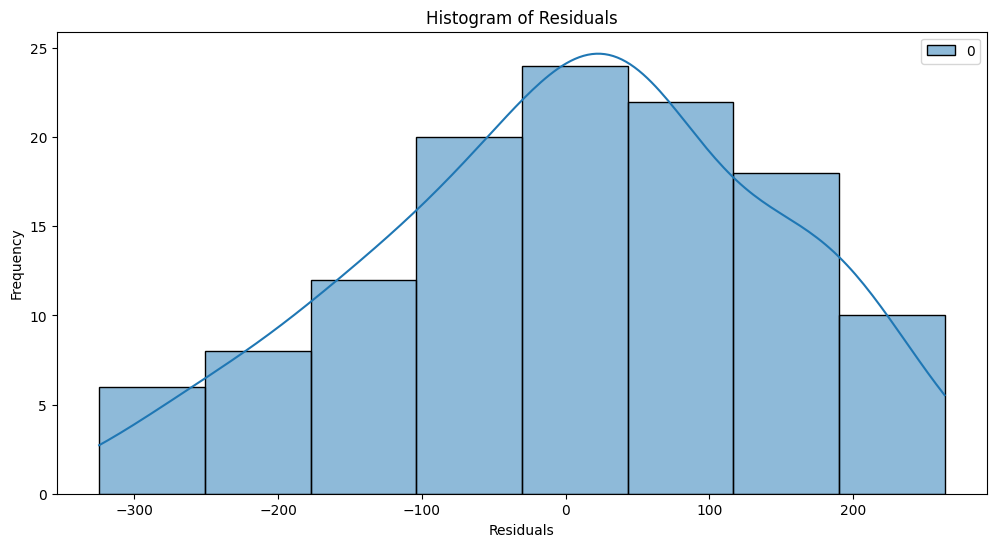

In [49]:
residual_analysis(residuals_final2)